# Upload files

In [0]:
# Uploading files from your local file system
# AmesHousing.txt

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [46]:
!gunzip 'listings.csv.gz'

gzip: listings.csv already exists; do you wish to overwrite (y or n)? y


In [47]:
!ls -l --block-size=M

total 112M
-rw-r--r-- 1 root root 112M Oct  3 20:57 listings.csv
drwxr-xr-x 2 root root   1M Sep 28 23:32 sample_data


# 1 - Introduction to K-Nearest Neighbors

## 1.1 - Problem definition




**AirBnB** is a marketplace for short term rentals that allows you to list part or all of your living space for others to rent. You can rent everything from a room in an apartment to your entire house on AirBnB. Because most of the listings are on a short-term basis, AirBnB has grown to become a popular alternative to hotels. The company itself has grown from it's founding in 2008 to a 30 billion dollar [valuation in 2016](http://www.bloomberg.com/news/articles/2016-08-05/airbnb-files-to-raise-850-million-at-30-billion-valuation) and is currently worth more than any hotel chain in the world.

One challenge that hosts looking to rent their living space face is determining the optimal nightly rent price. In many areas, renters are presented with a good selection of listings and can filter on criteria like price, number of bedrooms, room type and more. Since AirBnB is a marketplace, the amount a host can charge on a nightly basis is closely linked to the dynamics of the marketplace. Here's a screenshot of the search experience on AirBnB:

<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1pJqCJLih-jjSDtTF1m2j2bY8O_dGrj9M">

As a host, if we try to charge above market price for a living space we'd like to rent, then renters will select more affordable alternatives which are similar to ours.. If we set our nightly rent price too low, we'll miss out on potential revenue.

One strategy we could use is to:

- find a few listings that are similar to ours,
- average the listed price for the ones most similar to ours,
- set our listing price to this calculated average price.

The process of discovering patterns in existing data to make a prediction is called **machine learning**. In our case, we want to use data on local listings to predict the optimal price for us to set. In this lesson, we'll explore a specific machine learning technique called **k-nearest neighbors**, which mirrors the strategy we just described. Before we dive further into machine learning and k-nearest neighbors, let's get familiar with the dataset we'll be working with.

## 1.2 - Introduction to the data




While AirBnB doesn't release any data on the listings in their marketplace, a separate group named [Inside AirBnB](http://insideairbnb.com/get-the-data.html) has extracted data on a sample of the listings for many of the major cities on the website. In this lesson, we'll be working with their dataset from **September 14, 2018** on the listings from **Rio de Janeiro -Brazil**, the capital of the Samba. Here's a [direct link to that dataset](http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2018-09-14/data/listings.csv.gz). Each row in the dataset is a specific listing that's available for renting on AirBnB in the Rio de Janeiro.

To make the dataset less cumbersome to work with, we will removed many of the columns in the original dataset (96 columns). Here are the columns we will keep:

- **host_response_rate**: the response rate of the host
- **host_acceptance_rate**: number of requests to the host that convert to rentals
- **host_listings_count**: number of other listings the host has
- **latitude**: latitude dimension of the geographic coordinates
- **longitude**: longitude part of the coordinates
- **city**: the city the living space resides
- **zipcode**: the zip code the living space resides
- **state**: the state the living space resides
- **accommodates**: the number of guests the rental can accommodate
- **room_type**: the type of living space (Private room, Shared room or Entire home/apt
- **bedrooms**: number of bedrooms included in the rental
- **bathrooms**: number of bathrooms included in the rental
- **beds**: number of beds included in the rental
- **price**: nightly price for the rental
- **cleaning_fee**: additional fee used for cleaning the living space after the guest leaves
- **security_deposit**: refundable security deposit, in case of damages
- **minimum_nights**: minimum number of nights a guest can stay for the rental
- **maximum_nights**: maximum number of nights a guest can stay for the rental
- **number_of_reviews**: number of reviews that previous guests have left

Let's read the dataset into Pandas and become more familiar with it.



In [27]:
import pandas as pd

target_columns = ["host_response_rate", "host_acceptance_rate", "host_listings_count",
                  "latitude","longitude","city","zipcode","state","accommodates",
                  "room_type","bedrooms","bathrooms","beds","price","cleaning_fee",
                  "security_deposit","minimum_nights","maximum_nights","number_of_reviews"]

rio_listings = pd.read_csv("listings.csv",usecols=target_columns,low_memory=False)

rio_listings.head()

,host_response_rate,host_acceptance_rate,host_listings_count,city,state,zipcode,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,minimum_nights,maximum_nights,number_of_reviews
0,100%,NaN,3.0,Copacabana,Rio de Janeiro,22071-020,-22.978083,-43.190977,Entire home/apt,4,1.0,1.0,2.0,$179.00,NaN,$120.00,3,45,6
1,100%,NaN,12.0,Rio de Janeiro,Rio de Janeiro,22071-100,-22.981783,-43.193041,Entire home/apt,4,1.0,0.0,1.0,$150.00,$330.00,$120.00,2,1125,1
2,70%,NaN,1.0,Rio de Janeiro,Rio de Janeiro,22081-020,-22.983729,-43.192207,Entire home/apt,5,3.0,2.0,2.0,$250.00,$0.00,$120.00,1,1125,45
3,100%,NaN,1.0,Copacabana,Rio de Janeiro,22070-001,-22.983367,-43.190687,Entire home/apt,4,1.0,0.0,2.0,$150.00,$0.00,$100.00,2,14,0
4,92%,NaN,2.0,Rio de Janeiro,Rio de Janeiro,22061-020,-22.976700,-43.192468,Entire home/apt,4,1.0,1.0,3.0,$50.00,"$1,500.00",$150.00,3,1125,1


## 1.3 -  K-nearest neighbors




Here's the strategy we wanted to use:

- Find a few similar listings.
- Calculate the average nightly rental price of these listings.
- Set the average price as the price for our listing.

The k-nearest neighbors algorithm is similar to this strategy. Here's an overview:

<img width="900" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1b3uN7WtvbamsIVxYYML1cXbWTXvs6UGb">


There are 2 things we need to unpack in more detail:

- the similarity metric
- how to choose the **k** value

In this section, we'll define what similarity metric we're going to use. Then, we'll implement the **k-nearest neighbors** algorithm and use it to suggest a price for a new, unpriced listing. We'll use a **k** value of 5 in this section. In later sections, we'll learn how to evaluate how good the suggested prices are, how to choose the optimal **k** value, and more.


## 1.4 Euclidean distance




The similarity metric works by comparing a fixed set of numerical **features**, another word for attributes, between 2 **observations**, or living spaces in our case. When trying to predict a continuous value, like price, the main similarity metric that's used is **Euclidean distance**. Here's the general formula for Euclidean distance:

$\displaystyle d = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + \ldots + (q_n - p_n)^2}$

where $q_1$ to $q_n$ represent the feature values for one observation and $p_1$ to $p_n$ represent the feature values for the other observation. Here's a diagram that breaks down the Euclidean distance between the first 2 observations in the dataset using only the **host_listings_count**, **accommodates**, **bedrooms**, **bathrooms**, and **beds** columns:


<img width="900" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=15wH6nSdX74TEKIFeBqNrMceiwoCk5j3s">

In this mission, we'll use just one feature in this mission to keep things simple as you become familiar with the machine learning workflow. Since we're only using one feature, this is known as the **univariate case**. Here's how the formula looks like for the univariate case:

$\displaystyle d = \sqrt{(q_1 - p_1)^2}$

The square root and the squared power cancel and the formula simplifies to:

$ \displaystyle d = \left | q_1 - p_1 \right |$

The living space that we want to rent can accommodate 3 people. Let's first calculate the distance, using just the **accommodates** feature, between the first living space in the dataset and our own.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">



1. Calculate the Euclidean distance between our living space, which can accommodate 3 people, and the first living space in the **rio_listings** Dataframe. For the sake of understanding, use only the column "accommodates".
2. Assign the result to **first_distance** and display the value using the **print** function.

In [28]:
# put your code here
first_distance = ((3 - rio_listings.loc[0, 'accommodates'])**2)**0.5
print(first_distance)

1.0


 ## 1.5. Calculate distance for all observations




The Euclidean distance between the first row in the **rio_listings** Dataframe and our own living space is **1**. How do we know if this is high or low? If you look at the Euclidean distance equation itself, the lowest value you can achieve is **0**. This happens when the value for the feature is exactly the same for both observations you're comparing. If $p_1=q_1$, then $ \displaystyle d = \left | q_1 - p_1 \right |$ which results in $d=0$. The closer to **0** the distance the more similar the living spaces are.

If we wanted to calculate the Euclidean distance between each living space in the dataset and a living space that accommodates **8** people, here's a preview of what that would look like.

<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1res4uO-8wP8_g7scMbr1kP594ZnOmk-y">

Then, we can rank the existing living spaces by ascending distance values, the proxy for similarity.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">




1. Calculate the distance between each value in the **accommodates** column from **rio_listings** and the value **3**, which is the number of people our listing accommodates:
    - Use the [apply](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) method to calculate the absolute value between each value in **accommodates** and **3** and return a new Series containing the distance values.
2. Assign the distance values to the **distance** column.
3. Use the Series method **value_counts** and the **print** function to display the unique value counts for the **distance** column.

In [33]:
# put your code here
distance = rio_listings['accommodates'].apply(lambda row: ((3 - row)**2)**0.5)
rio_listings['distance'] = distance
print(distance.value_counts())

1.0      19102
2.0       5283
3.0       5078
0.0       3575
5.0       1511
4.0        840
7.0        779
9.0        296
13.0       266
6.0        249
12.0        86
11.0        76
8.0         60
10.0        43
157.0        1
Name: accommodates, dtype: int64


## 1.6 -  Randomizing, and sorting




It looks like there are quite a few, 3575 to be precise, living spaces that can accommodate 3 people just like ours. This means the 5 "nearest neighbors" we select after sorting all will have a distance value of 0. If we sort by the **distance** column and then just select the first 5 living spaces, we would be **biasing** the result to the ordering of the dataset.

```python
dc_listings[dc_listings["distance"] == 0]["accommodates"]
26      3
34      3
36      3
40      3
44      3
45      3
48      3
65      3
66      3
71      3
75      3
86      3
...
```

Let's instead randomize the ordering of the dataset and then sort the Dataframe by the **distance** column. This way, all of the living spaces with the same number of bedrooms will still be at the top of the Dataframe but will be in random order across the first 3575 rows. We've already done the first step of setting the random seed, so we can perform answer checking on our end.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">



1. Randomize the order of the rows in **rio_listings**:
    - Use the **np.random.permutation()** function to return a NumPy array of shuffled index values.
    - Use the Dataframe method **loc[]** to return a new Dataframe containing the shuffled order.
    - Assign the new Dataframe back to **rio_listings**.
2. After randomization, sort **rio_listings** by the **distance** column.
3. Display the first 10 values in the **price** column using the **print** function.

In [0]:
# put your code here
import numpy as np
np.random.seed(1)
arr = np.random.permutation(len(rio_listings))
rio_listings = rio_listings.loc[arr]

In [39]:
sorted_df = rio_listings.sort_values(by='distance')
print(sorted_df.price.head(10))

13455     350.0
34724     150.0
23922    1101.0
14190     150.0
35241     200.0
34155     538.0
2197      150.0
14590     300.0
7939      359.0
1260      121.0
Name: price, dtype: float64


## 1.7 -  Average price




Before we can select the 5 most similar living spaces and compute the average price, we need to clean the **price** column. Right now, the **price** column contains comma characters (**,**) and dollar sign characters and is formatted as a text column instead of a numeric one. We need to remove these values and convert the entire column to the float datatype. Then, we can calculate the average price.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">



1. Remove the commas (**,**) and dollar sign characters (**$**) from the **price** column:
    - Use the **str** accessor so we can apply string methods to each value in the column followed by the string method replace to replace all comma characters with the empty character: **stripped_commas = rio_listings['price'].str.replace(',', '')**
    - Repeat to remove the dollar sign characters as well.
2. Convert the new Series object containing the cleaned values to the **float** datatype and assign back to the **price** column in **rio_listings**.
3. Calculate the mean of the first 5 values in the **price** column and assign to **mean_price**.
4. Use the **print** function or the variable inspector below to display **mean_price**

In [0]:
# put your code here
stripped_commas = rio_listings['price'].str.replace(',', '')
stripped_dollar = stripped_commas.str.replace('$', '')
rio_listings['price'] = stripped_dollar.astype('float')

In [37]:
mean_price = rio_listings.iloc[:5]['price'].mean()
print(mean_price)

321.0


## 1.8 Function to make predictions



Congrats! You've just made your first prediction! Based on the average price of other listings that accommdate 3 people, we should charge **357.09** dollars per night for a guest to stay at our living space. In the next section, we'll dive into evaluating how good of a prediction this is.

Let's write a more general function that can suggest the optimal price for other values of the **accommodates** column. The **rio_listings** Dataframe has information specific to our living space, e.g. the **distance** column. To save you time, we've reset the **rio_listings** Dataframe to a clean state and only kept the data cleaning and randomization we did since those weren't unique to the prediction we were making for our living space.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


1. Write a function named **predict_price** that can use the **k-nearest neighbors machine learning** technique to calculate the suggested price for any value for **accommodates**. This function should:
    - Take in a single parameter, **new_listing**, that describes the **number of bedrooms**.
    - Assign **rio_listings** to a new Dataframe named **temp_df** so we aren't constantly modifying the original dataset each time we call the function.
    - Calculate the distance between each value in the **accommodates** column and the **new_listing** value that was passed in. Assign the resulting Series object to the **distance** column in **temp_df**.
    - Sort **temp_df** by the **distance** column and select the first 5 values in the **price** column. Don't randomize the ordering of **temp_df**.
    - Calculate the mean of these 5 values and use that as the return value for the entire **predict_price** function.
2. Use the **predict_price** function to suggest a price for a living space that:
    - accommodates 1 person, assign the suggested price to **acc_one**.
    - accommodates 2 people, assign the suggested price to **acc_two**.
    - accommodates 4 people, assign the suggested price to **acc_four**.

In [0]:
# Brought along the changes we made to the 'rio_listings' Dataframe.
target_columns = ["host_response_rate", "host_acceptance_rate", "host_listings_count",
                  "latitude","longitude","city","zipcode","state","accommodates",
                  "room_type","bedrooms","bathrooms","beds","price","cleaning_fee",
                  "security_deposit","minimum_nights","maximum_nights","number_of_reviews"]

rio_listings = pd.read_csv("listings.csv",usecols=target_columns,low_memory=False)

stripped_commas = rio_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
rio_listings['price'] = stripped_dollars.astype('float')
rio_listings = rio_listings.loc[np.random.permutation(len(rio_listings))]

def predict_price(new_listing):
    temp_df = rio_listings
    temp_df['distance'] = temp_df['accommodates'].apply(lambda row: ((new_listing - row)**2)**0.5)
    first_five = temp_df.sort_values(by='distance').loc[:5, 'price']

    return first_five.mean()

acc_one = predict_price(1)
acc_two = predict_price(2)
acc_four = predict_price(4)

In [41]:
print(acc_one)
print(acc_two)
print(acc_four)

257.35434023112066
270.9554101354436
530.7412514555372


## 1.9 - Next steps




In this section, we explored the problem of predicting the optimal price to list an AirBnB rental for based on the price of similar listings on the site. We stepped through the entire machine learning workflow, from selecting a feature to testing the model. To explore the basics of machine learning, we limited ourselves to only using one feature (the univariate case) and a fixed **k** value.

In the next section, we'll learn how to evaluate a model's performance.

# 2 -  Evaluating Model Performance

## 2.1 - Testing quality of predictions





We now have a function that can predict the price for any living space we want to list as long as we know the number of people it can accommodate. The function we wrote represents a **machine learning model**, which means that it outputs a prediction based on the input to the model.

A simple way to test the quality of your model is to:

- split the dataset into 2 partitions:
    - the **training set**: contains the majority of the rows (75%)
    - the **test set**: contains the remaining minority of the rows (25%)
- use the rows in the training set to predict the **price** value for the rows in the test set
    - add new column named **predicted_price** to the test set
- compare the **predicted_price** values with the actual  **price** values in the test set to see how accurate the predicted values were.

This validation process, where we use the training set to make predictions and the test set to predict values for, is known as **train/test validation**. Whenever you're performing machine learning, you want to perform validation of some kind to ensure that your machine learning model can make good predictions on new data. While train/test validation isn't perfect, we'll use it to understand the validation process, to select an error metric, and then we'll dive into a more robust validation process later in this lesson.

Let's modify the **predicted_price** function to use only the rows in the training set, instead of the full dataset, to find the nearest neighbors, average the **price** values for those rows, and return the predicted price value. Then, we'll use this function to predict the price for just the rows in the test set. Once we have the predicted price values, we can compare with the true price values and start to understand the model's effectiveness in the next screen.

To start, we've gone ahead and assigned the first 75% of the rows in **rio_listings** to **train_df** and the last 25% of the rows to **test_df**. Here's a diagram explaining the split:


<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1H3_0jjS2n8YeVzshom8if0-gB7FVP8WL">

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 

1. Within the **predict_price** function, change the Dataframe that **temp_df** is assigned to. Change it from **rio_listings** to **train_df**, so only the training set is used.
2. Use the Series method **apply** to pass all of the values in the **accommodates** column from **test_df** through the **predict_price** function.
3. Assign the resulting Series object to the **predict_price** column in **test_df**.

In [50]:
# importing packages
import pandas as pd
import numpy as np

# Brought along the changes we made to the 'rio_listings' Dataframe.
target_columns = ["host_response_rate", "host_acceptance_rate", "host_listings_count",
                  "latitude","longitude","city","zipcode","state","accommodates",
                  "room_type","bedrooms","bathrooms","beds","price","cleaning_fee",
                  "security_deposit","minimum_nights","maximum_nights","number_of_reviews"]

rio_listings = pd.read_csv("listings.csv",usecols=target_columns,low_memory=False)

# cleaning & preparing
stripped_commas = rio_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
rio_listings['price'] = stripped_dollars.astype('float')

# separte data into train and test (75%/25%)
train_df = rio_listings.iloc[0:int(rio_listings.shape[0]*0.75)]
test_df = rio_listings.iloc[int(rio_listings.shape[0]*0.75):]

def predict_price(new_listing):
    temp_df = train_df.copy()
    temp_df['distance'] = temp_df['accommodates'].apply(lambda x: np.abs(x - new_listing))
    temp_df = temp_df.sort_values('distance')
    nearest_neighbor_prices = temp_df.iloc[0:5]['price']
    predicted_price = nearest_neighbor_prices.mean()
    return(predicted_price)
  
# put your code here
test_df['predict_price'] = test_df['accommodates'].apply(predict_price)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 2.2 - Error Metrics




We now need a metric that quantifies how good the predictions were on the test set. This class of metrics is called an **error metric**. As the name suggests, an error metric quantifies how inaccurate our predictions were from the actual values. In our case, the error metric tells us how off our predicted price values were from the actual price values for the living spaces in the test dataset.

We could start by calculating the difference between each predicted and actual value and then averaging these differences. This is referred to as **mean error** but isn't an effective error metric for most cases. Mean error treats a positive difference differently than a negative difference, but we're really interested in how far off the prediction is in either the positive or negative direction. If the true price was 200 dollars and the model predicted 210 or 190 it's off by 10 dollars either way.

We can instead use the **mean absolute error**, where we compute the absolute value of each error before we average all the errors.

$\displaystyle MAE = \frac{\left | actual_1 - predicted_1 \right | + \left | actual_2 - predicted_2 \right | + \
\ldots + \left | actual_n - predicted_n \right | }{n}$

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 

1. Use **numpy.absolute()** to calculate the mean absolute error between **predicted_price** and **price**.
2. Assign the MAE to **mae**.

In [51]:
# put your code here
import numpy as np

mae = np.sum(np.absolute(test_df['price'] - test_df['predict_price']))/len(test_df['price'])
print(mae)

663.5728737113403


## 2.3 - Mean Squared Error




For many prediction tasks, we want to penalize predicted values that are further away from the actual value much more than those that are closer to the actual value.

We can instead take the mean of the squared error values, which is called the **mean squared error** or MSE for short. The MSE makes the gap between the predicted and actual values more clear. A prediction that's off by 100 dollars will have an error (of 10,000) that's 100 times more than a prediction that's off by only 10 dollars (which will have an error of 100).

Here's the formula for MSE:

$\displaystyle MSE = \frac{(actual_1 - predicted_1)^2 + (actual_2 - predicted_2)^2 + \
\ldots + (actual_n - predicted_n)^2 }{n}$

where **n** represents the number of rows in the test set. Let's calculate the MSE value for the predictions we made on the test set.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 

1. Calculate the MSE value between the **predicted_price** and **price** columns and assign to **mse**.

In [53]:
# put your code here
mse = np.sum(((test_df['price'] - test_df['predict_price'])**2))/len(test_df['price'])
print(mse)

3383052.8908032645


## 2.4 -  Training another model

The model we trained achieved a mean squared error of around **3383052**. Is this a high or a low mean squared error value? What does this tell us about the quality of the predictions and the model? By itself, the mean squared error value for a single model isn't all that useful.

The units of mean squared error in our case is dollars squared (not dollars), which makes it hard to reason about intuitively as well. We can, however, train another model and then compare the mean squared error values to see which model performs better on a relative basis. Recall that a low error metric means that the gap between the predicted list price and actual list price values is low while a high error metric means the gap is high.

Let's train another model, this time using the **bathrooms** column, and compare MSE values.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 


1. Modify the **predict_price** function below to use the **bathrooms** column instead of the **accommodates** column to make predictions.
2. Apply the function to **test_df** and assign the resulting Series object containing the predicted price values to the **predicted_price** column in **test_df**.
3. Calculate the squared error between the price and **predicted_price** columns in **test_df** and assign the resulting Series object to the **squared_error** column in **test_df**.
4. Calculate the mean of the **squared_error** column in **test_df** and assign to **mse**.

In [55]:
# separte data into train and test (75%/25%)
train_df = rio_listings.iloc[0:int(rio_listings.shape[0]*0.75)]
test_df = rio_listings.iloc[int(rio_listings.shape[0]*0.75):]

def predict_price(new_listing):
    temp_df = train_df.copy()
    temp_df['distance'] = temp_df['bathrooms'].apply(lambda x: np.abs(x - new_listing))
    temp_df = temp_df.sort_values('distance')
    nearest_neighbors_prices = temp_df.iloc[0:5]['price']
    predicted_price = nearest_neighbors_prices.mean()
    return(predicted_price)
  
# put your code here
test_df['predict_price'] = test_df['bathrooms'].apply(predict_price)
test_df['squared_error'] = (test_df['price'] - test_df['predict_price']) ** 2
mse = test_df['squared_error'].mean()
print(mse)

2603479.935408076


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## 2.5 - Root Mean Squared Error




While comparing MSE values helps us identify which model performs better on a relative basis, it doesn't help us understand if the performance is good enough in general. This is because the units of the MSE metric are squared (in this case, dollars squared). An MSE value of 2603479 dollars squared doesn't give us an intuitive sense of how far off the model's predictions are systematically off from the true price value in dollars.

**Root mean squared error** is an error metric whose units are the base unit (in our case, dollars). RMSE for short, this error metric is calculated by taking the square root of the MSE value:

$\displaystyle RMSE=\sqrt{MSE}$

Since the RMSE value uses the same units as the target column, we can understand how far off in real dollars we can expect the model to perform. For example, if a model achieves an RMSE value of greater than 100, we can expect the predicted price value to be off by 100 dollars on average.

Let's calculate the RMSE value of the model we trained using the **bathrooms** column.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 



1. Calculate the RMSE value of the model we trained using the **bathrooms** column and assign it to **rmse**.


In [56]:
# put your code here
rmse = np.sqrt(mse)
print(rmse)

1613.5302709921732


# 3 - Multivariate K-Nearest Neighbors

## 3.1. Recap




In the last two sections, we explored how to use a simple k-nearest neighbors machine learning model that used just one feature, or attribute, of the listing to predict the rent price. We first relied on the **accommodates** column, which describes the number of people a living space can comfortably accommodate. Then, we switched to the **bathrooms** column and observed an improvement in accuracy. 

While these were good features to become familiar with the basics of machine learning, it's clear that using just a single feature to compare listings doesn't reflect the reality of the market. An apartment that can accommodate 4 guests in a popular part of **Rio de Janeiro**. will rent for much higher than one that can accommodate 4 guests in a crime ridden area.

There are **2 ways** we can tweak the model to try **to improve the accuracy** (decrease the RMSE during validation):

- **increase the number of attributes** the model uses to calculate similarity when ranking the closest neighbors
- **increase k**, the number of nearby neighbors the model uses when computing the prediction


In this section, we'll focus on increasing the number of attributes the model uses. When selecting more attributes to use in the model, we need to watch out for columns that don't work well with the distance equation. This includes columns containing:

- **non-numerical values** (e.g. city or state)
    - Euclidean distance equation expects numerical values
- **missing values**
    - distance equation expects a value for each observation and attribute
- **non-ordinal values** (e.g. latitude or longitude)
    - ranking by Euclidean distance doesn't make sense if all attributes aren't ordinal
    
In the following code screen, we've read the **listings.csv** dataset from the last section into pandas and brought over the data cleaning changes we made. Let's first look at the first row's values to identify any columns containing non-numerical or non-ordinal values. In the next screen, we'll drop those columns and then look for missing values in each of the remaining columns.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 


1. Use the **DataFrame.info()** method to return the number of non-null values in each column.



In [7]:
# importing packages
import pandas as pd
import numpy as np
np.random.seed(1)

# Brought along the changes we made to the 'rio_listings' Dataframe.
target_columns = ["host_response_rate", "host_acceptance_rate", "host_listings_count",
                  "latitude","longitude","city","zipcode","state","accommodates",
                  "room_type","bedrooms","bathrooms","beds","price","cleaning_fee",
                  "security_deposit","minimum_nights","maximum_nights","number_of_reviews"]

rio_listings = pd.read_csv("listings.csv",usecols=target_columns,low_memory=False)

rio_listings = rio_listings.loc[np.random.permutation(len(rio_listings))]
stripped_commas = rio_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
rio_listings['price'] = stripped_dollars.astype('float')

# put your code here
rio_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37245 entries, 3629 to 33003
Data columns (total 19 columns):
host_response_rate      18217 non-null object
host_acceptance_rate    0 non-null float64
host_listings_count     37237 non-null float64
city                    37224 non-null object
state                   37179 non-null object
zipcode                 35057 non-null object
latitude                37245 non-null float64
longitude               37245 non-null float64
room_type               37245 non-null object
accommodates            37245 non-null int64
bathrooms               37168 non-null float64
bedrooms                37219 non-null float64
beds                    37188 non-null float64
price                   37245 non-null float64
security_deposit        18540 non-null object
cleaning_fee            23159 non-null object
minimum_nights          37245 non-null int64
maximum_nights          37245 non-null int64
number_of_reviews       37245 non-null int64
dtypes: float6

## 3.2 - Removing features




The following columns contain non-numerical values:

- **room_type**: e.g. **Private room**
- **city**: e.g. **Rio de Janeiro**
- **state**: e.g. **RJ**

while these columns contain numerical but non-ordinal values:

- **latitude**: e.g. **-22.92**
- **longitude**: e.g. **-43.23**
- **zipcode**: e.g. **20550-012**


Geographic values like these aren't ordinal, because a smaller numerical value doesn't directly correspond to a smaller value in a meaningful way. For example, the zip code 20009 isn't smaller or larger than the zip code 75023 and instead both are unique, identifier values. Latitude and longitude value pairs describe a point on a geographic coordinate system and different equations are used in those cases (e.g. [haversine](https://en.wikipedia.org/wiki/Haversine_formula)).

While we could convert the **host_response_rate** and **host_acceptance_rate** columns to be numerical (right now they're object data types and contain the **%** sign), these columns describe the host and not the living space itself. Since a host could have many living spaces and we don't have enough information to uniquely group living spaces to the hosts themselves, let's avoid using any columns that don't directly describe the living space or the listing itself:

- **host_response_rate**
- **host_acceptance_rate**
- **host_listings_count**

Let's remove these 9 columns from the Dataframe

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 

1. Remove the 9 columns we discussed above from **rio_listings**:
    - 3 containing non-numerical values
    - 3 containing numerical but non-ordinal values
    - 3 describing the host instead of the living space itself
2. Verify the number of null values of each remain columns



In [8]:
# put your code here
columns_to_drop = ['room_type', 'city', 'state', 'latitude', 'longitude', 'zipcode', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count']
rio_listings = rio_listings.drop(columns_to_drop, axis=1)
rio_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37245 entries, 3629 to 33003
Data columns (total 10 columns):
accommodates         37245 non-null int64
bathrooms            37168 non-null float64
bedrooms             37219 non-null float64
beds                 37188 non-null float64
price                37245 non-null float64
security_deposit     18540 non-null object
cleaning_fee         23159 non-null object
minimum_nights       37245 non-null int64
maximum_nights       37245 non-null int64
number_of_reviews    37245 non-null int64
dtypes: float64(4), int64(4), object(2)
memory usage: 3.1+ MB


## 3.3 - Handling missing values



Of the remaining columns, 3 columns have a few missing values (less than 1% of the total number of rows):

- **bedrooms**
- **bathrooms**
- **beds**

Since the number of rows containing missing values for one of these 3 columns is low, we can select and remove those rows without losing much information. There are also 2 columns have a large number of missing values:

- **cleaning_fee** - 37.81% of the rows
- **security_deposit** - 50.22% of the rows

and we can't handle these easily. We can't just remove the rows containing missing values for these 2 columns because we'd miss out on the majority of the observations in the dataset. Instead, let's remove these 2 columns entirely from consideration.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 

1. Drop the **cleaning_fee** and **security_deposit** columns from **rio_listings**.
2. Then, remove all rows that contain a missing value for the **bedrooms**, **bathrooms**, or **beds** column from **rio_listings**.
    - You can accomplish this by using the [Dataframe method dropna()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html) and setting the **axis** parameter to **0**.
    - Since only the **bedrooms**, **bathrooms** and **beds** columns contain any missing values, rows containing missing values in these columns will be removed.
3. Display the null value counts for the updated **rio_listings** Dataframe to confirm that there are no missing values left.

In [9]:
# put your code here
rio_listings.drop(['cleaning_fee', 'security_deposit'], inplace=True, axis=1)
rio_listings.dropna(axis=0, inplace=True)
rio_listings.isnull().sum()

accommodates         0
bathrooms            0
bedrooms             0
beds                 0
price                0
minimum_nights       0
maximum_nights       0
number_of_reviews    0
dtype: int64

## 3.4 -  Normalize columns




Here's how the **rio_listings** Dataframe looks like after all the changes we made:

|  |accommodates | bathrooms | bedrooms | beds | price | minimum_nights | maximum_nights | number_of_reviews |    
|--------------|-----------|----------|------|-------|----------------|----------------|-------------------|----|
| 3629         | 8         | 1.0      | 1.0  | 1.0   | 200.0          | 2              | 60                | 0  |
| 15971        | 6         | 2.0      | 3.0  | 4.0   | 901.0          | 10             | 27                | 0  |
| 34100        | 2         | 1.0      | 1.0  | 1.0   | 229.0          | 2              | 50                | 24 |
| 35013        | 2         | 1.0      | 1.0  | 2.0   | 200.0          | 3              | 1125              | 0  |
| 35992        | 2         | 2.0      | 1.0  | 1.0   | 75.0           | 2              | 30                | 2  |

You may have noticed that while the **accommodates**, **bedrooms**, **bathrooms**, **beds**, and **minimum_nights** columns hover between 0 and 10 (at least in the first few rows), the values in the **maximum_nights** and **number_of_reviews** columns span much larger ranges. For example, the **maximum_nights** column has values as low as 27 and high as 1125, in the first few rows itself. If we use these 2 columns as part of a k-nearest neighbors model, these attributes could end up having an outsized effect on the distance calculations because of the largeness of the values.

For example, 2 living spaces could be identical across every attribute but be vastly different just on the **maximum_nights** column. If one listing had a **maximum_nights** value of 1125 and the other a **maximum_nights** value of 27, because of the way Euclidean distance is calculated, these listings would be considered very far apart because of the outsized effect the largeness of the values had on the overall Euclidean distance. To prevent any single column from having too much of an impact on the distance, we can **normalize** all of the columns to have a mean of 0 and a standard deviation of 1.

Normalizing the values in each columns to the [standard normal distribution](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution) (mean of 0, standard deviation of 1) preserves the distribution of the values in each column while aligning the scales. To normalize the values in a column to the standard normal distribution, you need to:

- from each value, subtract the mean of the column
- divide each value by the standard deviation of the column

Here's the mathematical formula describing the transformation that needs to be applied for all values in a column:

$\displaystyle z= \frac{x − \mu}{\sigma}$

where x is a value in a specific column, $\mu$ is the mean of all the values in the column, and $\sigma$ is the standard deviation of all the values in the column. Here's what the corresponding code, using pandas, looks like:

```python
# Subtract each value in the column by the mean.
first_transform = rio_listings['maximum_nights'] - rio_listings['maximum_nights'].mean()
# Divide each value in the column by the standard deviation.
normalized_col = first_transform / rio_listings['maximum_nights'].std()
```

To apply this transformation across all of the columns in a Dataframe, you can use the corresponding Dataframe methods mean() and std():

```python
normalized_listings = (rio_listings - rio_listings.mean()) / (rio_listings.std())
```

These methods were written with mass column transformation in mind and when you call **mean()** or **std()**, the appropriate column means and column standard deviations are used for each value in the Dataframe. Let's now normalize all of the feature columns in **rio_listings**.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 

1. Normalize all of the feature columns in **rio_listings** and assign the new Dataframe containing just the normalized feature columns to **normalized_listings**.
2. Add the price column from **rio_listings** to **normalized_listings**.
3. Display the first 3 rows in **normalized_listings**.
4. Use the function **describe** to see min and max values in **normalized_listings**.
5. Don't forget to eliminate outliers under **normalized_listings**. (note: this can be a little bit more difficult than previous exercises)

In [10]:
# put your code here
normalized_listings = (rio_listings - rio_listings.mean()) / rio_listings.std()
normalized_listings['price'] = rio_listings['price']
print(normalized_listings.head(3))
normalized_listings.describe()

       accommodates  bathrooms  bedrooms      beds  price  minimum_nights  \
3629       1.455731  -0.675561 -0.597141 -0.779634  200.0       -0.121916   
15971      0.691689   0.270036  1.229006  0.664997  901.0        0.254255   
34100     -0.836394  -0.675561 -0.597141 -0.779634  229.0       -0.121916   

       maximum_nights  number_of_reviews  
3629        -0.008480          -0.337023  
15971       -0.008483          -0.337023  
34100       -0.008481           0.981921  


,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
count,3.712900e+04,3.712900e+04,3.712900e+04,3.712900e+04,37129.000000,3.712900e+04,3.712900e+04,3.712900e+04
mean,-1.314721e-16,-4.592913e-18,-4.822558e-17,-4.478090e-17,645.284872,-2.066811e-17,7.654855e-19,2.387358e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1658.580291,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.218415e+00,-1.621158e+00,-1.510215e+00,-1.261178e+00,0.000000,-1.689371e-01,-8.484452e-03,-3.370226e-01
25%,-8.363938e-01,-6.755609e-01,-5.971412e-01,-7.796344e-01,150.000000,-1.689371e-01,-8.482279e-03,-3.370226e-01
50%,-7.235234e-02,-6.755609e-01,-5.971412e-01,-2.980906e-01,296.000000,-1.219157e-01,-8.400222e-03,-3.370226e-01
75%,3.096684e-01,2.700359e-01,3.159325e-01,1.834533e-01,626.000000,-2.787293e-02,-8.400222e-03,-1.721546e-01
max,5.952288e+01,1.729078e+01,3.957810e+01,2.281602e+01,41719.000000,5.733824e+01,1.609190e+02,1.647951e+01


In [0]:
#removing outliers
outliers = normalized_listings.apply(lambda col: col[(col < col.mean() - 3 * col.std()) | (col > col.mean() + 3 * col.std())]).index
normalized_listings.drop(outliers, inplace=True)

## 3.5 - Euclidean distance for multivariate case




In the last section, we trained 2 univariate k-nearest neighbors models. The first one used the **accommodates** attribute while the second one used the **bathrooms** attribute. Let's now train a model that uses **both** attributes when determining how similar 2 living spaces are. Let's refer to the Euclidean distance equation again to see what the distance calculation using 2 attributes would look like:

$\displaystyle d = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + \ldots + (q_n - p_n)^2}$

Since we're using 2 attributes, the distance calculation would look like:

$\displaystyle d = \sqrt{(accommodates_1 - accomodates_2)^2 + (bathrooms_1 - bathrooms_2)^2}$


To find the distance between 2 living spaces, we need to calculate the squared difference between both **accommodates** values, the squared difference between both **bathrooms** values, add them together, and then take the square root of the resulting sum. Here's what the Euclidean distance between the first 2 rows in **normalized_listings** looks like:

<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=15uoTMT1rzRLx9T8kIbsOWw7HaTmdBP0o">


So far, we've been calculating Euclidean distance ourselves by writing the logic for the equation ourselves. We can instead use the [distance.euclidean()](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.euclidean.html) function from **scipy.spatial**, which takes in 2 vectors as the parameters and calculates the Euclidean distance between them. The **euclidean()** function expects:

- both of the vectors to be represented using a **list-like** object (Python list, NumPy array, or pandas Series)
- both of the vectors must be 1-dimensional and have the same number of elements

Here's a simple example:

```python
from scipy.spatial import distance
first_listing = [-0.596544, -0.439151]
second_listing = [-0.596544, 0.412923]
dist = distance.euclidean(first_listing, second_listing)
```

Let's use the **euclidean()** function to calculate the Euclidean distance between 2 rows in our dataset to practice.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 

1. Calculate the Euclidean distance using only the **accommodates** and **bathrooms** features between the first row and fifth row in **normalized_listings** using the **distance.euclidean()** function.
2. Assign the distance value to **first_fifth_distance** and display using the **print** function.


In [12]:
# put your code here
from scipy.spatial import distance

distance.euclidean(normalized_listings.iloc[:5]['accommodates'], normalized_listings.iloc[:5]['bathrooms'])

2.4486968563760394

## 3.6 -  Introduction to scikit-learn




So far, we've been writing functions from scratch to train the **k-nearest neighbor models**. While this is helpful deliberate practice to understand how the mechanics work, you can be more productive and iterate quicker by using a library that handles most of the implementation. In this subsection, we'll learn about the [scikit-learn library](http://scikit-learn.org/), which is the most popular machine learning in Python. Scikit-learn contains functions for all of the major machine learning algorithms and a simple, unified workflow. Both of these properties allow data scientists to be incredibly productive when training and testing different models on a new dataset.

The scikit-learn workflow consists of 4 main steps:

- instantiate the specific machine learning model you want to use
- fit the model to the training data
- use the model to make predictions
- evaluate the accuracy of the predictions


We'll focus on the first 3 steps in this section. Each model in scikit-learn is implemented as a [separate class](http://scikit-learn.org/dev/modules/classes.html) and the first step is to identify the class we want to create an instance of. In our case, we want to use the [KNeighborsRegressor class](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor).
Any model that helps us predict numerical values, like listing price in our case, is known as a **regression** model. The other main class of machine learning models is called classification, where we're trying to predict a label from a fixed set of labels (e.g. blood type or gender). The word **regressor** from the class name **KNeighborsRegressor** refers to the regression model class that we just discussed.

Scikit-learn uses a similar object-oriented style to Matplotlib and you need to instantiate an empty model first by calling the constructor:

```python
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
```

If you refer to the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor), you'll notice that by default:

- **n_neighbors:**  the number of neighbors, is set to **5**
- **algorithm:** for computing nearest neighbors, is set to **auto**
- **p:** set to **2**, corresponding to Euclidean distance

Let's set the **algorithm** parameter to **brute** and leave the **n_neighbors** value as **5**, which matches the implementation we wrote in the last mission. If we leave the **algorithm** parameter set to the default value of **auto**, scikit-learn will try to use tree-based optimizations to improve performance (which are outside of the scope of this lesson):

```python
knn = KNeighborsRegressor(algorithm='brute')
```


## 3.7 - Fitting a model and making predictions




Now, we can fit the model to the data using the [fit method](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.fit). For all models, the **fit** method takes in 2 required parameters:

- matrix-like object, containing the feature columns we want to use from the training set.
- list-like object, containing correct target values.

Matrix-like object means that the method is flexible in the input and either a Dataframe or a NumPy 2D array of values is accepted. This means you can select the columns you want to use from the Dataframe and use that as the first parameter to the **fit** method.

If you recall from earlier in the mission, all of the following are acceptable list-like objects:

- NumPy array
- Python list
- pandas Series object (e.g. when selecting a column)

You can select the target column from the Dataframe and use that as the second parameter to the **fit** method:


```python
# Split full dataset into train and test sets.
train_df = normalized_listings.iloc[0:int(normalized_listings.shape[0]*0.75)]
test_df = normalized_listings.iloc[int(normalized_listings.shape[0]*0.75):]
# Matrix-like object, containing just the 2 columns of interest from training set.
train_features = train_df[['accommodates', 'bathrooms']]
# List-like object, containing just the target column, `price`.
train_target = normalized_listings['price']
# Pass everything into the fit method.
knn.fit(train_features, train_target)
```


When the **fit** method is called, scikit-learn stores the training data we specified within the KNearestNeighbors instance (**knn**). If you try passing in data containing missing values or non-numerical values into the **fit** method, scikit-learn will return an error. Scikit-learn contains many such features that help prevent us from making common mistakes.

Now that we specified the training data we want used to make predictions, we can use the [predict method](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.predict) to make predictions on the test set. The **predict** method has only one required parameter:

- matrix-like object, containing the feature columns from the dataset we want to make predictions on

The number of feature columns you use during both training and testing need to match or scikit-learn will return an error:

```python
predictions = knn.predict(test_df[['accommodates', 'bathrooms']])
```

The **predict()** method returns a NumPy array containing the predicted **price** values for the test set. You now have everything you need to practice the entire scikit-learn workflow.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 
1. Create an instance of the [KNeighborsRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) class with the following parameters:
    - **n_neighbors**: 5
    - **algorithm**: brute
2. Use the **fit** method to specify the data we want the k-nearest neighbor model to use. Use the following parameters:
    - training data, feature columns: just the **accommodates** and **bathrooms** columns, in that order, from **train_df**.
    - training data, target column: the **price** column from **train_df**.
3. Call the **predict** method to make predictions on:
    - the **accommodates** and **bathrooms** columns from **test_df**
    - assign the resulting NumPy array of predicted price values to **predictions**.

In [0]:
from sklearn.neighbors import KNeighborsRegressor

# Split full dataset into train and test sets.
train_df = normalized_listings.iloc[0:int(normalized_listings.shape[0]*0.75)]
test_df = normalized_listings.iloc[int(normalized_listings.shape[0]*0.75):]

# put your code here
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')
knn.fit(train_df[['accommodates', 'bathrooms']], train_df['price'])
predictions = knn.predict(test_df[['accommodates', 'bathrooms']])

## 3.8 - Calculating MSE using Scikit-Learn





Earlier in this mission, we calculated the MSE and RMSE values using the pandas arithmetic operators to compare each predicted value with the actual value from the **price** column of our test set. Alternatively, we can instead use the [sklearn.metrics.mean_squared_error function()](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error). Once you become familiar with the different machine learning concepts, unifying your workflow using scikit-learn helps save you a lot of time and avoid mistakes.

The **mean_squared_error()** function takes in 2 inputs:

- list-like object, representing the true values
- list-like object, representing the predicted values using the model

For this function, we won't show any sample code and will leave it to you to understand the function from the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) itself to calculate the MSE and RMSE values for the predictions we just made.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 

1. Use the **mean_squared_error** function to calculate the MSE value for the predictions we made in the previous exercise.
2. Assign the MSE value to **two_features_mse**.
3. Calculate the RMSE value by taking the square root of the MSE value and assign to **two_features_rmse**.
4. Display both of these error scores using the **print** function.
5. Using more features and compare the results.

In [14]:
from sklearn.metrics import mean_squared_error

# features
train_columns = ['accommodates', 'bathrooms']

# instantiate a knn object
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='euclidean')

# train the model
knn.fit(train_df[train_columns], train_df['price'])

# predict
predictions = knn.predict(test_df[train_columns])

# put your code here
two_features_mse = mean_squared_error(test_df['price'], predictions)
two_features_rmse = np.sqrt(two_features_mse)
print('MSE: ', str(two_features_mse))
print('RMSE: ', str(two_features_rmse))

MSE:  338635.00318682595
RMSE:  581.9235372339101


In [15]:
train_columns = ['accommodates', 'bathrooms', 'bedrooms']

# instantiate a knn object
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='euclidean')

# train the model
knn.fit(train_df[train_columns], train_df['price'])

# predict
predictions = knn.predict(test_df[train_columns])

# put your code here
two_features_mse = mean_squared_error(test_df['price'], predictions)
two_features_rmse = np.sqrt(two_features_mse)
print('MSE: ', str(two_features_mse))
print('RMSE: ', str(two_features_rmse))

MSE:  316799.0906320306
RMSE:  562.8490833536381


# 4 - Hyperparameter Optimization

## 4.1 Recap

In the last section, we focused on increasing the number of attributes the model uses. We saw how, in general, adding more attributes generally lowered the error of the model. This is because the model is able to do a better job identifying the living spaces from the training set that are the most similar to the ones from the test set. However, we also observed how using all of the available features didn't actually improve the model's accuracy automatically and that some of the features were probably not relevant for similarity ranking. We learned that selecting relevant features was the right lever when improving a model's accuracy, not just increasing the features used in the absolute.

In this section, we'll focus on the impact of increasing **k**, the number of nearby neighbors the model uses to make predictions. 


In [0]:
# Split full dataset into train and test sets.
train_df = normalized_listings.iloc[0:int(normalized_listings.shape[0]*0.75)]
test_df = normalized_listings.iloc[int(normalized_listings.shape[0]*0.75):]

## 4.2 - Hyperparameters

When we vary the features that are used in the model, we're affecting the data that the model uses. On the other hand, varying the k value affects the behavior of the model independently of the actual data that's used when making predictions. In other words, we're impacting how the model performs without trying to change the data that's used.

Values that affect the behavior and performance of a model that are unrelated to the data that's used are referred to as **hyperparameters**. The process of finding the optimal hyperparameter value is known as **hyperparameter optimization**. A simple but common [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization) technique is known as [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search), which involves:

- selecting a subset of the possible hyperparameter values,
- training a model using each of these hyperparameter values,
- evaluating each model's performance,
- selecting the hyperparameter value that resulted in the lowest error value.

Grid search essentially boils down to evaluating the model performance at different k values and selecting the k value that resulted in the lowest error. While grid search can take a long time when working with large datasets, the data we're working with in this section is small and this process is relatively quick.

Let's confirm that grid search will work quickly for the dataset we're working with by first observing how the model performance changes as we increase the k value from **1** to **5**. If you recall, we set **5** as the **k** value for the last 2 sections. Let's use the features from the last mission:

- **accommodates**
- **bedrooms**
- **bathrooms**
- **number_of_reviews**


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 

1. Create a list containing the integer values **1**, **2**, **3**, $\ldots$, **20**, in that order, and assign to **hyper_params**.
2. Create an empty list and assign to **mse_values**.
3. Use a **for loop** to iterate over **hyper_params** and in each iteration:
    - Instantiate a **KNeighborsRegressor** object with the following parameters:
        - **n_neighbors**: the current value for the iterator variable,
        - **algorithm**: brute
    - Fit the instantiated k-nearest neighbors model to the following columns from **train_df**:
        - **accommodates**
        - **bedrooms**
        - **bathrooms**
        - **number_of_reviews**
    - Use the trained model to make predictions on the same columns from **test_df** and assign to **predictions**.
    - Use the **mean_squared_error** function to calculate the MSE value between **predictions** and the **price** column from **test_df**.
    - Append the MSE value to **mse_values**.
4. Display **mse_values** using the **print()** function.
5. Calculate the **rmse** from **mse_values**. Use **print()** function to display **rmse**. 
6. Use the seaborn to generate a scatter plot with:
    - **hyper_params** on the x-axis,
    - **mse_values** on the y-axis.
7. Use plt.show() to display the scatter plot.
8. Try to find a combination of features which reach the best results.

In [17]:
# put your code here
hyper_params = list(range(1, 21))
mse_values = []
train_cols = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']
for h in hyper_params:
  knn = KNeighborsRegressor(n_neighbors = h, algorithm = 'brute')
  knn.fit(train_df[train_cols], train_df['price'])
  predictions = knn.predict(test_df[train_cols])
  mse_values.append(mean_squared_error(test_df['price'], predictions))

print(mse_values)
print(np.sqrt(mse_values))

[367970.141250145, 318460.9169082686, 313887.70274588634, 299129.1911820132, 291321.29787776875, 284768.49045189226, 282159.87520087475, 276688.0581910298, 270831.3226140826, 267750.03530673776, 265553.0708090893, 265310.23604185187, 264614.5751852586, 264163.0299406902, 264489.4220608965, 263048.24394515395, 263384.84567104874, 263427.8748641661, 263921.4781768015, 264233.1469247941]
[606.60542468 564.32341517 560.25681856 546.92704375 539.74188079
 533.63703999 531.18723178 526.01146203 520.41456803 517.44568344
 515.31841691 515.08274679 514.40701316 513.96792696 514.28535081
 512.88229054 513.21033278 513.25225266 513.73288602 514.03613387]


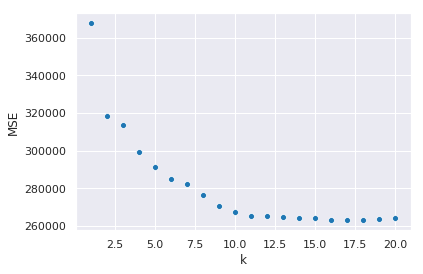

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("darkgrid")

sns.scatterplot(hyper_params, mse_values)
plt.xlabel("k")
plt.ylabel("MSE")
plt.show()

In [23]:
print("The better k is: ")
index = mse_values.index(min(mse_values))
print(hyper_params[index])
print('The MSE is ', str(min(mse_values)))

The better k is: 
16
The MSE is  263048.24394515395


# 5 - Cross-Validation

## 5.1 Introduction


In an earlier sections, we learned about train/test validation, a simple technique for testing a machine learning model's accuracy on new data that the model wasn't trained on. In this section, we'll focus on more robust techniques.

To start, we'll focus on the **holdout validation** technique, which involves:

- splitting the full dataset into 2 partitions:
    - a training set
    - a test set
- training the model on the training set,
- using the trained model to predict values on the test set,
- computing an error metric to understand the model's effectiveness,
- switch the training and test sets and repeat,
- average the errors.

In holdout validation, we usually use a 50/50 split instead of the 75/25 split from train/test validation. This way, we remove number of observations as a potential source of variation in our model performance.

<img width="400" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1Nwq2puuGhziyQ82eukrPctHQ8UGJ93Vt">

Let's start by splitting the data set into 2 nearly equivalent halves.


In [0]:
# Split full dataset into two splits dataset
split_one_df = normalized_listings.iloc[0:int(normalized_listings.shape[0]*0.5)]
split_two_df = normalized_listings.iloc[int(normalized_listings.shape[0]*0.5):]

## 5.2 - Holdout Validation




Now that we've split our data set into 2 dataframes, let's:

- train a k-nearest neighbors model on the first half,
- test this model on the second half,
- train a k-nearest neighbors model on the second half,
- test this model on the first half.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 

- Train a k-nearest neighbors model using the default algorithm (**auto**) and the default number of neighbors (**5**) that:
    - Uses the **accommodates** column from **train_one** for training and
    - Tests it on  **test_one**.
- Assign the resulting RMSE value to **iteration_one_rmse**.
- Train a k-nearest neighbors model using the default algorithm (**auto**) and the default number of neighbors (**5**) that:
    - Uses the **accommodates** column from **train_two** for training and
    - Tests it on  **test_two**.
- Assign the resulting RMSE value to **iteration_two_rmse**.
- Use **numpy.mean()** to calculate the average of the 2 RMSE values and assign to **avg_rmse**.

In [0]:
# put your code here
knn = KNeighborsRegressor()
knn.fit(split_one_df[['accommodates']], split_one_df['price'])
predictions_one = knn.predict(split_two_df[['accommodates']])
iteration_one_rmse = np.sqrt(mean_squared_error(split_two_df['price'], predictions_one))

knn = KNeighborsRegressor()
knn.fit(split_two_df[['accommodates']], split_two_df['price'])
predictions_two = knn.predict(split_one_df[['accommodates']])
iteration_two_rmse = np.sqrt(mean_squared_error(split_one_df['price'], predictions_two))

In [0]:
avg_rmse = np.mean([iteration_one_rmse, iteration_two_rmse])

## 5.3 - K-Fold Cross Validation



**Holdout validation** is actually a specific example of a larger class of validation techniques called **k-fold cross-validation**. While holdout validation is better than train/test validation because the model isn't repeatedly biased towards a specific subset of the data, both models that are trained only use half the available data. K-fold cross validation, on the other hand, takes advantage of a larger proportion of the data during training while still rotating through different subsets of the data to avoid the issues of train/test validation.

Here's the algorithm from k-fold cross validation:

- splitting the full dataset into **k** equal length partitions,
    - selecting **k-1** partitions as the training set and
    - selecting the remaining partition as the test set
- training the model on the training set,
- using the trained model to predict labels on the test fold,
- computing the test fold's error metric,
- repeating all of the above steps **k-1** times, until each partition has been used as the test set for an iteration,
- calculating the mean of the **k** error values.

Holdout validation is essentially a version of k-fold cross validation when **k** is equal to **2**. Generally, **5** or **10** folds is used for k-fold cross-validation. Here's a diagram describing each iteration of 5-fold cross validation:

<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1i9sScUbJqDLeCtd3InrBbaeHXI7vkAyQ">


As you increase the number the folds, the number of observations in each fold decreases and the variance of the fold-by-fold errors increases. 

## 5.4 - Performing K-Fold Cross Validation Using Scikit-Learn


In machine learning, we're interested in building a good model and accurately understand how well it will perform. To build a better k-nearest neighbors model, we can change the features it uses or tweak the number of neighbors (a hyperparameter). To accurately understand a model's performance, we can perform k-fold cross validation and select the proper number of folds. We've learned how scikit-learn makes it easy for us to quickly experiment with these different knobs when it comes to building a better model. Let's now dive into how we can use scikit-learn to handle cross-validation as well.


First, we instantiate an instance of the [KFold class](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) from  **sklearn.model_selection**:

```python
from sklearn.model_selection import KFold
kf = KFold(n_folds, shuffle=False, random_state=None)
```

where:

- **n_folds** is the number of folds you want to use,
- **shuffle** is used to toggle shuffling of the ordering of the observations in the dataset,
- **random_state** is used to specify the random seed value if **shuffle** is set to **True**.


You'll notice here that no parameters depend on the data set at all. This is because the KFold class returns an iterator object which we use in conjunction with the [cross_val_score()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function, also from **sklearn.model_selection**. Together, these 2 functions allow us to compactly train and test using k-fold cross validation:

Here are the relevant parameters for the **cross_val_score** function:

```python
from sklearn.model_selection import cross_val_score
cross_val_score(estimator, X, Y, scoring=None, cv=None)
```

where:

- **estimator** is a sklearn model that implements the **fit** method (e.g. instance of **KNeighborsRegressor**),
-  **X** is the list or 2D array containing the features you want to train on,
- **Y** is a list containing the values you want to predict (target column),
- **scoring** is a string describing the scoring criteria (list of accepted values [here](http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)).
    - Some evaluation metrics (like mean squared error) are naturally descending scores (the smallest score is best) and as such are reported as negative by the  **cross_val_score()** function. This is important to note, because some scores will be reported as negative that by definition can never be negative.
- **cv** describes the number of folds. Here are some examples of accepted values:
    - an instance of the **KFold** class,
    - an integer representing the number of folds.
    
Depending on the scoring criteria you specify, either a single total value is returned one value for each fold. Here's the general workflow for performing k-fold cross-validation using the classes we just described:

- instantiate the scikit-learn model class you want to fit,
- instantiate the **KFold** class and using the parameters to specify the k-fold cross-validation attributes you want,
- use the **cross_val_score()** function to return the scoring metric you're interested in.

**Guided Exercise**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 


In [30]:
from sklearn.model_selection import cross_val_score, KFold

# kfold instance
kf = KFold(5, shuffle=True, random_state=1)

# knn model
model = KNeighborsRegressor()

# cross validation (knn,x,y,scoring,kfold)
mses = cross_val_score(model, 
                       normalized_listings[["accommodates"]], 
                       normalized_listings["price"], 
                       scoring="neg_mean_squared_error", 
                       cv=kf)

# root mean squared error
rmses = np.sqrt(np.absolute(mses))

# average error
avg_rmse = np.mean(rmses)

print(rmses)
print(avg_rmse)

[577.88093299 561.91259209 559.17989717 591.93935339 575.92920847]
573.3683968216928


## 5.5 - Exploring Different K Values




Choosing the right **k** value when performing k-fold cross validation is **more of an art and less of a science**. As we discussed earlier in the lesson, a **k** value of **2** is really just holdout validation. On the other end, setting **k** equal to **n** (the number of observations in the data set) is known as **leave-one-out cross validation**, or **LOOCV** for short. Through lots of trial and error, data scientists have converged on **10** as the standard **k** value.

In the following code block, we display the results of varying **k** from **3 to 23**. For each **k** value, we calculate and display the average RMSE value across all of the folds and the standard deviation of the RMSE values. 

**Guided Exercise**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">
 


In [31]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

num_folds = [3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 23]

for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor()
    mses = cross_val_score(model, normalized_listings[["accommodates"]],
                           normalized_listings["price"], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))

3 folds:  avg RMSE:  582.0185649608411 std RMSE:  6.315721887126509
5 folds:  avg RMSE:  573.3683968216928 std RMSE:  11.868868110044303
7 folds:  avg RMSE:  591.4411387460058 std RMSE:  17.46826201894321
9 folds:  avg RMSE:  601.1051755643408 std RMSE:  37.21117543356968
10 folds:  avg RMSE:  600.9770783463956 std RMSE:  44.67564100634466
11 folds:  avg RMSE:  608.9597963412178 std RMSE:  43.42286124791362
13 folds:  avg RMSE:  604.8324921641665 std RMSE:  31.07881348103493
15 folds:  avg RMSE:  614.7905144658187 std RMSE:  29.2694837225671
17 folds:  avg RMSE:  596.4614524531977 std RMSE:  33.195858828458015
19 folds:  avg RMSE:  599.9110690020202 std RMSE:  32.481971441415986
21 folds:  avg RMSE:  600.5644806693205 std RMSE:  36.146355920832534
23 folds:  avg RMSE:  601.9677873627476 std RMSE:  38.57559277821402


## 5.6 - Bias-Variance Tradeoff




So far, we've been working under the assumption that a lower RMSE always means that a model is more accurate. This isn't the complete picture, unfortunately. 
A model has two sources of error:

- **bias**
- **variance**.

**Bias** describes error that results in bad assumptions about the learning algorithm. For example, assuming that only one feature, like a car's weight, relates to a car's fuel efficiency will lead you to fit a simple, univariate regression model that will result in high bias. The error rate will be high since a car's fuel efficiency is affected by many other factors besides just its weight.

**Variance** describes error that occurs because of the variability of a model's predicted values. If we were given a dataset with 1000 features on each car and used every single feature to train an incredibly complicated multivariate regression model, we will have low bias but high variance. In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

The standard deviation of the RMSE values can be a proxy for a model's **variance** while the average RMSE is a proxy for a model's **bias**. Bias and variance are the 2 observable sources of error in a model that we can indirectly control.

<img width="500" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1HHIrhAPERrQlzslS1dn3PTy78MaAERhu">


While k-nearest negihbors can make predictions, it isn't a mathematical model. A mathematical model is usually an equation that can exist without the original data, which isn't true with k-nearest neighbors. In the next classes, we'll learn about a mathematical model called linear regression. We'll explore the bias-variance tradeoff in greater depth in these next 2 courses because of its importance when working with mathematical models in particular.
